

## Symbolic regression detection of laws



In [1]:

using Kinbiont
using SymbolicRegression
using Plots
using StatsBase
using Distributions



In this example, we simulate data for a single species. The growth rate depends on an experimental feature, and we assume the user does not know the exact relationship between this feature and the growth rate but it can manipulate and register the value of this feature.
We conduct the experiment under different conditions and fit the data using a simple ODE model.
Afterward, we apply symbolic regression between the experimental feature and the fitted growth rates the to discover the relationship.

The function `unknown_response` defines the relationship between the experimental feature and the growth rate, where the growth rate is altered as a function of the feature.


In [2]:

function unknown_response(feature)
    response = 1 / (1 + feature)
    return response
end



unknown_response (generic function with 1 method)


We use the `baranyi_richards` ODE model in this example. First, we define the parameter ranges and the inital guess  for the fit:



In [3]:


ODE_models = "baranyi_richards"

# Parameter bounds and initial guess
ub_1 = [0.2, 5.1, 500.0, 5.0]
lb_1 = [0.0001, 0.1, 0.00, 0.2]
p1_guess = lb_1 .+ (ub_1 .- lb_1) ./ 2



4-element Vector{Float64}:
   0.10005000000000001
   2.6
 250.0
   2.6


Next, we define the feature range and simulation parameters:


In [6]:


# Range of experimental feature
feature_range = 0.0:0.4:4.0;

# Simulation parameters
p_sim = [0.1, 1.0, 50.0, 1.0];
psim_1_0 = p_sim[1];

# Time range for simulation
t_min = 0.0;
t_max = 800.0;
n_start = [0.1];  # Initial population size
delta_t = 5.0 ; # Time step
noise_value = 0.02 ;# Noise for simulation
results_fit = Any;





We loop through different feature values, modify the growth rate according to the `unknown_response`, and run the simulation. We also add noise to the simulated data.


In [7]:



# for over the generated feature values
for f in feature_range
    # Modify the parameter for the current feature
    p_sim[1] = psim_1_0 * unknown_response(f)

    # Run the simulation with Kinbiont
    sim = Kinbiont.ODE_sim("baranyi_richards", n_start, t_min, t_max, delta_t, p_sim)

    # Adding uniform noise
    noise_uniform = rand(Uniform(-noise_value, noise_value), length(sim.t))

    # Collecting the simulated data
    data_t = reduce(hcat, sim.t)
    data_o = reduce(hcat, sim.u)
    data_OD = vcat(data_t, data_o)
    data_OD[2, :] = data_OD[2, :] .+ noise_uniform

   

    # Fit the ODE model to the data
    results_ODE_fit = fitting_one_well_ODE_constrained(
        data_OD,
        string(f),
        "test_ODE",
        "baranyi_richards",
        p1_guess;
        lb=lb_1,
        ub=ub_1
    )


    # Collect the fitted results for later use
    if f == feature_range[1]
        results_fit = results_ODE_fit[2]
    else
        results_fit = hcat(results_fit, results_ODE_fit[2])
    end
end






We now perform symbolic regression to discover the relationship between the feature and the effective growth rate. We set up the options for symbolic regression and generate a feature matrix based on the `feature_range`.


┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression /Users/fabrizio.angaroni/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                             ┫ 0/150 [00:00<00:-35, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.489e-03  3.604e+01  y = 0.062288                                  9           1.852e-03  3.696e-02  y = (((-0.7369 + x₁) - (1.211 - -0.80431)) * -0.038556)                                                                       ---------------------------------------------------------------------------------------------------
1.3%┣▋                                              ┫ 2/150 [00:00<01:07, 2it/s]Expressions evaluate

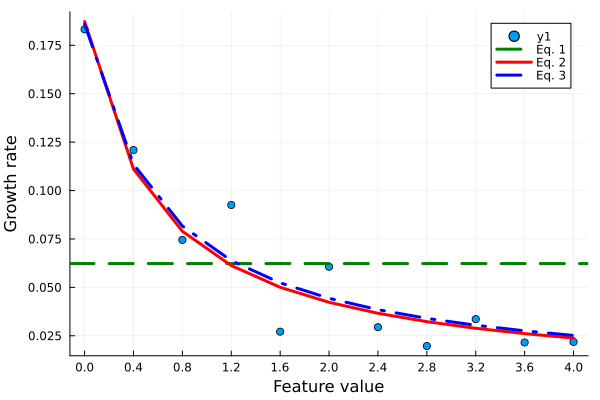

In [8]:


# Symbolic regression options
options = SymbolicRegression.Options(
    binary_operators=[+, /, *, -],
    unary_operators=[],
    constraints=nothing,
    elementwise_loss=nothing,
    loss_function=nothing,
    tournament_selection_n=12,
    tournament_selection_p=0.86,
    topn=12,
    complexity_of_operators=nothing,
    complexity_of_constants=nothing,
    complexity_of_variables=nothing,
    parsimony=0.05,
    dimensional_constraint_penalty=nothing,
    alpha=0.100000,
    maxsize=10,
    maxdepth=nothing
)

# Generating the feature matrix
feature_matrix = [[string(f), f] for f in feature_range]
feature_matrix = permutedims(reduce(hcat, feature_matrix))

# Performing symbolic regression
gr_sy_reg = Kinbiont.downstream_symbolic_regression(results_fit, feature_matrix, 4; options=options)

# Plot the growth rate with symbolic regression results
scatter(results_fit[2, :], results_fit[4, :], xlabel="Feature value", ylabel="Growth rate")
hline!(unique(gr_sy_reg[3][:, 1]), label=["Eq. 1" nothing], line=(3, :green, :dash))
plot!(unique(results_fit[2, :]), unique(gr_sy_reg[3][:, 2]), label=["Eq. 2" nothing], line=(3, :red))
plot!(unique(results_fit[2, :]), unique(gr_sy_reg[3][:, 3]), label=["Eq. 3" nothing], line=(3, :blue, :dashdot))





The Hall of fame can be visulalized looking into


In [9]:


gr_sy_reg[1]


4-element Vector{Node{Float64}}:
 0.06228779173952957
 (0.10923941020091434 / (x1 - -0.5833410013122617))
 (0.02709442358641499 / ((x1 * 0.23251336508912304) + 0.14569991715288386))
 ((0.0475361355673619 / ((x1 * 0.6335654247726188) - -0.39701130907847676)) / 0.6438732549561894)

In [10]:


gr_sy_reg[2]


3×5 Matrix{Any}:
 "Complexity"  …  9
 "MSE"            0.000198625
 "Equation"        "((0.0475361355673619 / ((x1 * 0" ⋯ 34 bytes ⋯ "7847676)) / 0.6438732549561894)"